In [81]:
import pandas as pd
import numpy as np
import pylab as pl
import scipy.io as sio
import seaborn as sns
import statsmodels.api as sm
import funcs as func
import sys
import pdb
import scipy.signal as sp_sig
import glob
import more_itertools as mit
import matplotlib.pyplot as plt
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

cwd = os.getcwd()

print(cwd)
data_dir = cwd+"/Data/Y_maze/data_with_animal_ids/"
data_target_dir = cwd+"/Data/processed_data/Y_maze/data_with_animal_ids/"
figure_dir = cwd+"/Figures/example_velocity_profiles/"


/home/jyotika/2-arm-bandit-task


In [82]:
#experiment_type = "NoConfLowVolDTs"

plt.rcParams["figure.facecolor"] = "w"

In [83]:
col_names = ["time (ms)","event_marker","current_trial_num_in_block","block","low_rew_%","high_rew_%","low_trial_range(block)","high_trial_range(block)","block#","rewarded_trial_count","total_trial_count","sig","x_pos","y_pos","trip","chnc","current_hall","previous_hall","lick_rate_hall1","lick_rate_hall2","lick_rate_hall3","wtr","mouse_distance","TTL"]

non_action_em = [0,11,12,9,10]
left_action_em = [1,2,3,4]
right_action_em = [5,6,7,8]
rewarded_em = [1,3,5,7]
unrewarded_em = [2,4,6,8]

In [84]:
def plot_velocity_profile(sub_dat,figure_dir,postfix):
    fig,ax = pl.subplots(1,1,figsize=(25,10))
    sns.lineplot(x="time (ms)",y="speed",data=sub_dat,ax=ax)
    sns.lineplot(x="time (ms)",y="speed_filt",data=sub_dat,ax=ax)

    # ind = np.where(np.logical_and(sub_dat["DT_markers_new"].values==1),sub_dat["current_hall"]!=0))[0]
    ind = np.where(sub_dat["DT_markers_new"].values==1)[0] #,sub_dat["current_hall"]!=0))[0]
    # ind = sp_sig.argrelmin(sub_dat["speed"].values)
    ax.plot(sub_dat.iloc[ind]["time (ms)"],sub_dat.iloc[ind]["speed_filt"],'.',color='green')

    trial_change = np.where(sub_dat["current_trial_num_in_block"]!=sub_dat["current_trial_num_in_block"].shift(1))[0] #)[0]
    ax.plot(sub_dat.iloc[trial_change]["time (ms)"],sub_dat.iloc[trial_change]["speed_filt"],'*',color='firebrick',ms=10)
    fn_postfix = "_".join(postfix)
    fig.subplots_adjust(left=0.03,right=0.97,bottom=0.06,top=0.96)
    fig.savefig(figure_dir+"velocity_profile_"+fn_postfix+".png")

In [85]:
def calc_decision_times(vel_prof,exp_type):
    dt_df = pd.DataFrame()
    conf = exp_type.split('Conf')[0]
    cond = exp_type.split('Vol')[1]
    #cond = "Control" # change when stim data is here !!!!!!
    vol = exp_type.split('Vol')[0].split('Conf')[1]
    print(conf,cond,vol)
    
    sessions = np.unique(vel_prof["session"])
    sess_to_plot = np.random.choice(sessions,1)[0]    
    block_nums = np.unique(vel_prof.loc[vel_prof["session"]==sess_to_plot]["block#"])
    block_to_plot = np.random.choice(block_nums,1)[0]
    animals = np.unique(vel_prof["animal_id"])
    an_to_plot = np.random.choice(animals,1)[0]
    print(sess_to_plot,block_to_plot,an_to_plot)
    to_plot = vel_prof.loc[(vel_prof["session"]==sess_to_plot)&(vel_prof["block#"]==block_to_plot)]
    #print(to_plot)
    plot_velocity_profile(to_plot,figure_dir,(str(sess_to_plot),str(block_to_plot),str(an_to_plot),conf,vol,cond))
    
    for grp in vel_prof.groupby(["session","block#","current_trial_num_in_block","animal_id"]):
#         print(grp[0])

#         to_plot = np.random.uniform(0,1.0,1)
#         if to_plot<0.4:
#             plot_velocity_profile(grp[1],figure_dir,(str(grp[0][0]),str(grp[0][1]),str(grp[0][3]),conf,vol,cond))
    
        temp = dict()
        temp["session"] = grp[0][0]
        temp["animal_id"] = int(grp[0][3])
        if temp["animal_id"]%2 == 0 and cond == "Stim": # even animal id
            cond1 = "dSPN-Stim"
        elif temp["animal_id"]%2 != 0 and cond == "Stim": # odd animal id
            cond1 = "iSPN-Stim"
        elif temp["animal_id"]%2 == 0 and cond == "Control": # even animal id
            cond1 = "dSPN-Control"
        elif temp["animal_id"]%2 != 0 and cond == "Control": # odd animal id
            cond1 = "iSPN-Control"
#         else:
#             cond1 = cond
        temp["conflict"] = conf
        temp["volatility"] = vol
        temp["condition"] = cond1
        temp["block_num"] = grp[0][1]
        temp["trial_num"] = grp[0][2]
        
        action_em = list(set(np.unique(grp[1]["event_marker"]))-set(non_action_em))
        #print(action_em)
        if len(action_em) == 1:
            ind_action_em = np.where(grp[1]["event_marker"]==action_em[0])[0]
            #uniq_chnc = np.unique(grp[1].iloc[ind_action_em]["chnc"])
            #if len(uniq_chnc) > 1:
            #    nz = np.where(uniq_chnc!=0)
                #uniq_chnc = uniq_chnc[nz]
            #print(ind_action_em)
            #else:
                #uniq_chnc 
            
            #temp["chnc"] = uniq_chnc
            
            #print(temp["chnc"])
        #print(action_em)       
        if len(action_em) == 1:
            temp["event_marker"] = action_em[0]
            if action_em[0] in left_action_em:
                temp["chosen_action"] = "left"
            elif action_em[0] in right_action_em:
                temp["chosen_action"] = "right"
            if action_em[0] in rewarded_em:
                temp["rewarded"] = "rewarded"
            elif action_em[0] in unrewarded_em:
                temp["rewarded"] = "unrewarded"
        else:
            #print("no action ems",np.unique(grp[1]["event_marker"]))
            #print(grp[0])
            temp["event_marker"] = np.nan
            temp["reward_probability"] = np.nan
            temp["chosen_action"] = np.nan
            temp["rewarded"] = np.nan

        temp["block"] = "left" if np.unique(grp[1]["block"])[0] == 0 else "right"
#         temp["trial_length_range"] = str(np.unique(grp[1]["low_trial_range(block)"])[0])+"-"+str(np.unique(grp[1]["high_trial_range(block)"])[0])

#         temp["reward_probability"] = str(np.unique(grp[1]["low_rew_%"])[0])+"-"+str(np.unique(grp[1]["high_rew_%"])[0])
        temp["optimal_action"] = 1 if temp["block"] == temp["chosen_action"] else 0
        
        ind = np.where(grp[1]["DT_markers_new"]==1)[0]
        if len(ind)==0:
            continue
#         print(ind)
#         print(grp[1]["DT_markers_new"])
        start = grp[1].iloc[ind[0]]["time (ms)"]
        end = grp[1].iloc[ind[-1]]["time (ms)"]
        rt = end - start
        temp["rt"] = rt
        
        dt_df = dt_df.append(temp,ignore_index=True)
    return dt_df
    
    

In [86]:
decision_times_all_conditions = pd.DataFrame()
exp_files = glob.glob(data_target_dir+"velocity_profiles*.csv")
print(exp_files)



['/home/jyotika/2-arm-bandit-task/Data/processed_data/Y_maze/data_with_animal_ids/velocity_profiles_LowConfLowVolStim.csv', '/home/jyotika/2-arm-bandit-task/Data/processed_data/Y_maze/data_with_animal_ids/velocity_profiles_NoConfLowVolControl.csv', '/home/jyotika/2-arm-bandit-task/Data/processed_data/Y_maze/data_with_animal_ids/velocity_profiles_NoConfHighVolControl.csv', '/home/jyotika/2-arm-bandit-task/Data/processed_data/Y_maze/data_with_animal_ids/velocity_profiles_HighConfLowVolControl.csv', '/home/jyotika/2-arm-bandit-task/Data/processed_data/Y_maze/data_with_animal_ids/velocity_profiles_LowConfHighVolControl.csv', '/home/jyotika/2-arm-bandit-task/Data/processed_data/Y_maze/data_with_animal_ids/velocity_profiles_HighConfHighVolStim.csv', '/home/jyotika/2-arm-bandit-task/Data/processed_data/Y_maze/data_with_animal_ids/velocity_profiles_NoConfLowVolStim.csv', '/home/jyotika/2-arm-bandit-task/Data/processed_data/Y_maze/data_with_animal_ids/velocity_profiles_HighConfLowVolStim.csv', 

/home/jyotika/2-arm-bandit-task/Data/processed_data/Y_maze/data_with_animal_ids/velocity_profiles_LowConfLowVolStim.csv
LowConfLowVolStim
Low Stim Low
10 8 1.0
/home/jyotika/2-arm-bandit-task/Data/processed_data/Y_maze/data_with_animal_ids/velocity_profiles_NoConfLowVolControl.csv
NoConfLowVolControl
No Control Low
6 17 1.0
/home/jyotika/2-arm-bandit-task/Data/processed_data/Y_maze/data_with_animal_ids/velocity_profiles_NoConfHighVolControl.csv
NoConfHighVolControl
No Control High
45 12 7.0
/home/jyotika/2-arm-bandit-task/Data/processed_data/Y_maze/data_with_animal_ids/velocity_profiles_HighConfLowVolControl.csv
HighConfLowVolControl
High Control Low
4 1.0 2.0
/home/jyotika/2-arm-bandit-task/Data/processed_data/Y_maze/data_with_animal_ids/velocity_profiles_LowConfHighVolControl.csv
LowConfHighVolControl
Low Control High
27 29 8.0
/home/jyotika/2-arm-bandit-task/Data/processed_data/Y_maze/data_with_animal_ids/velocity_profiles_HighConfHighVolStim.csv
HighConfHighVolStim
High Stim High
2

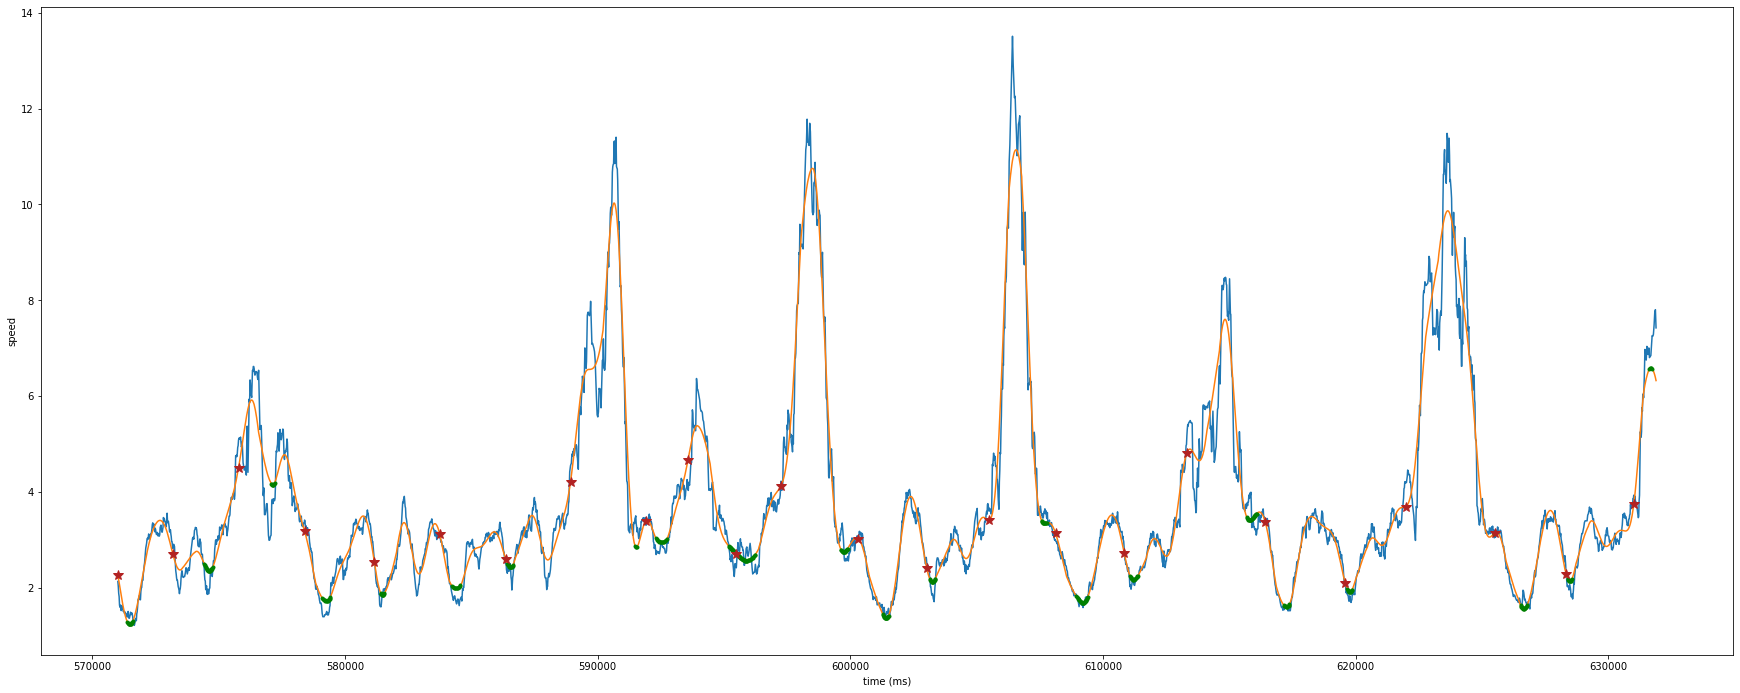

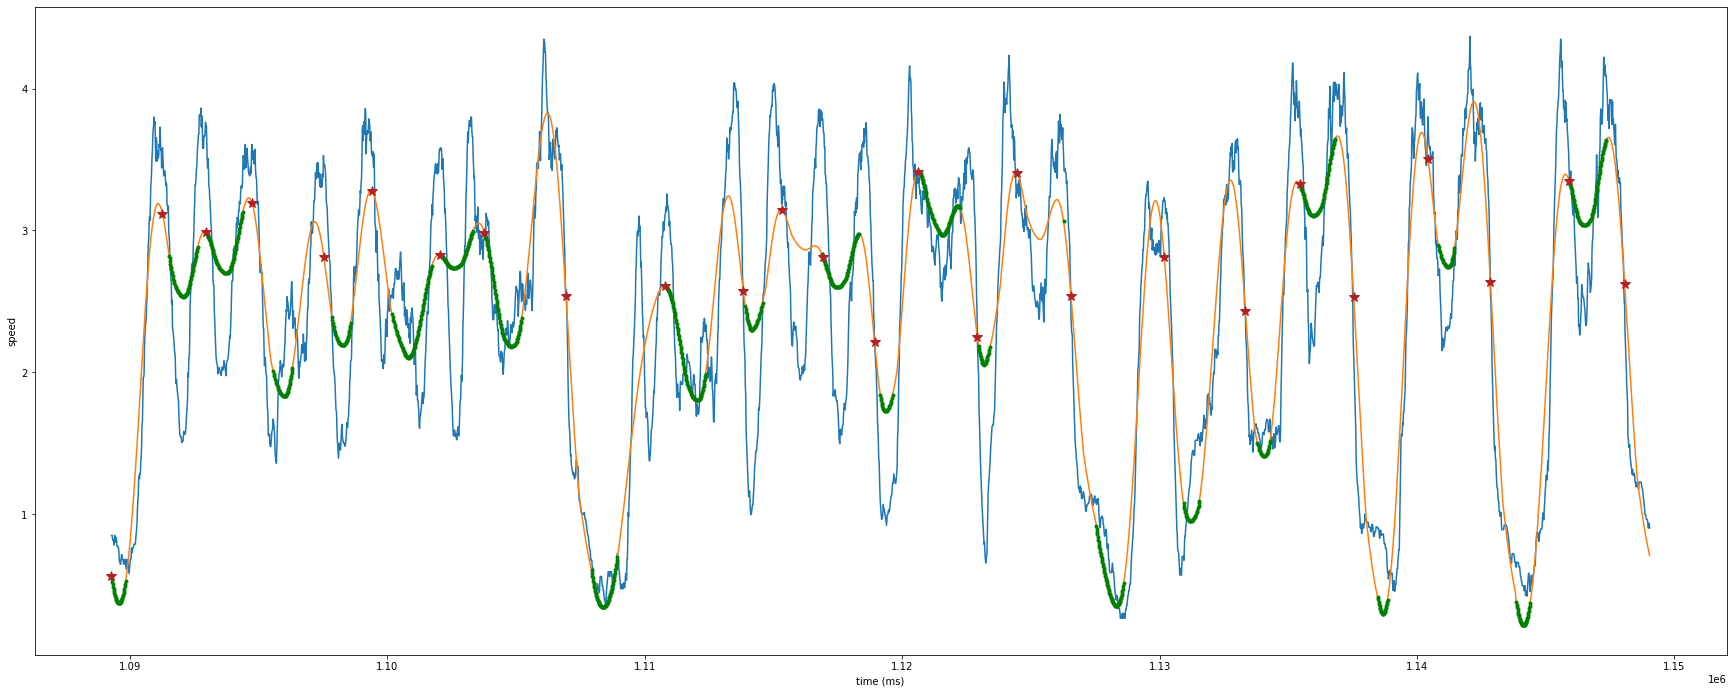

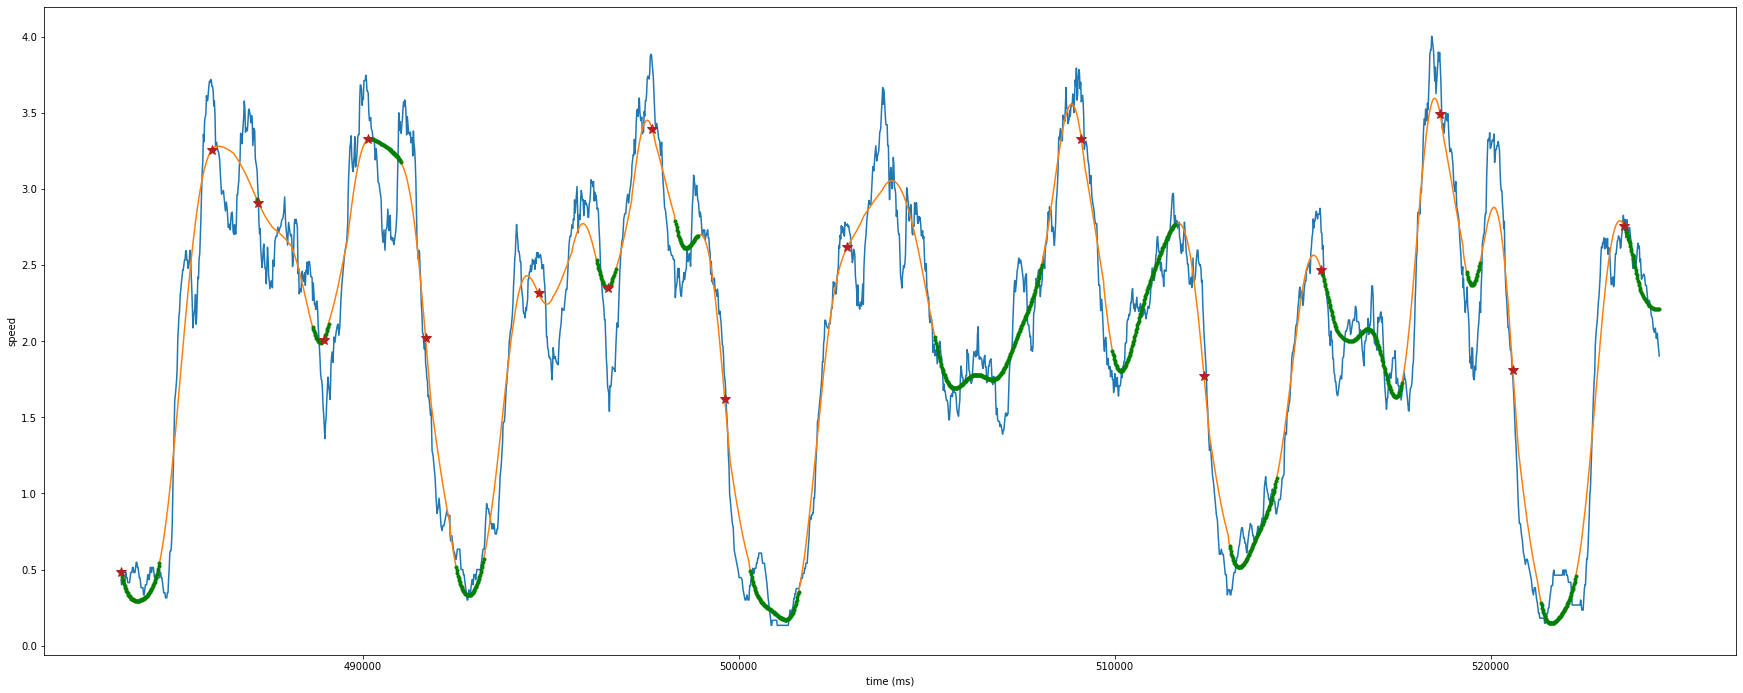

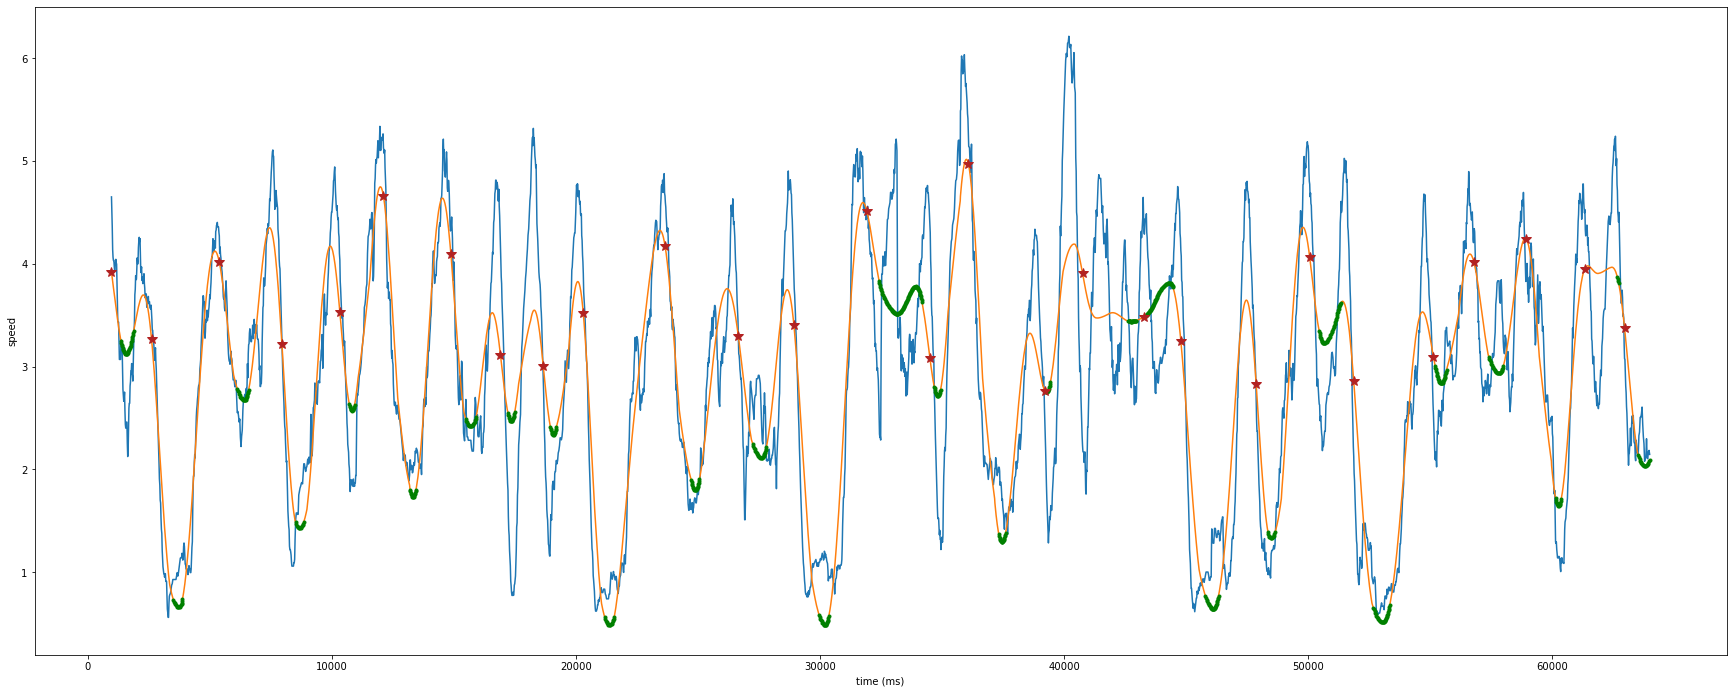

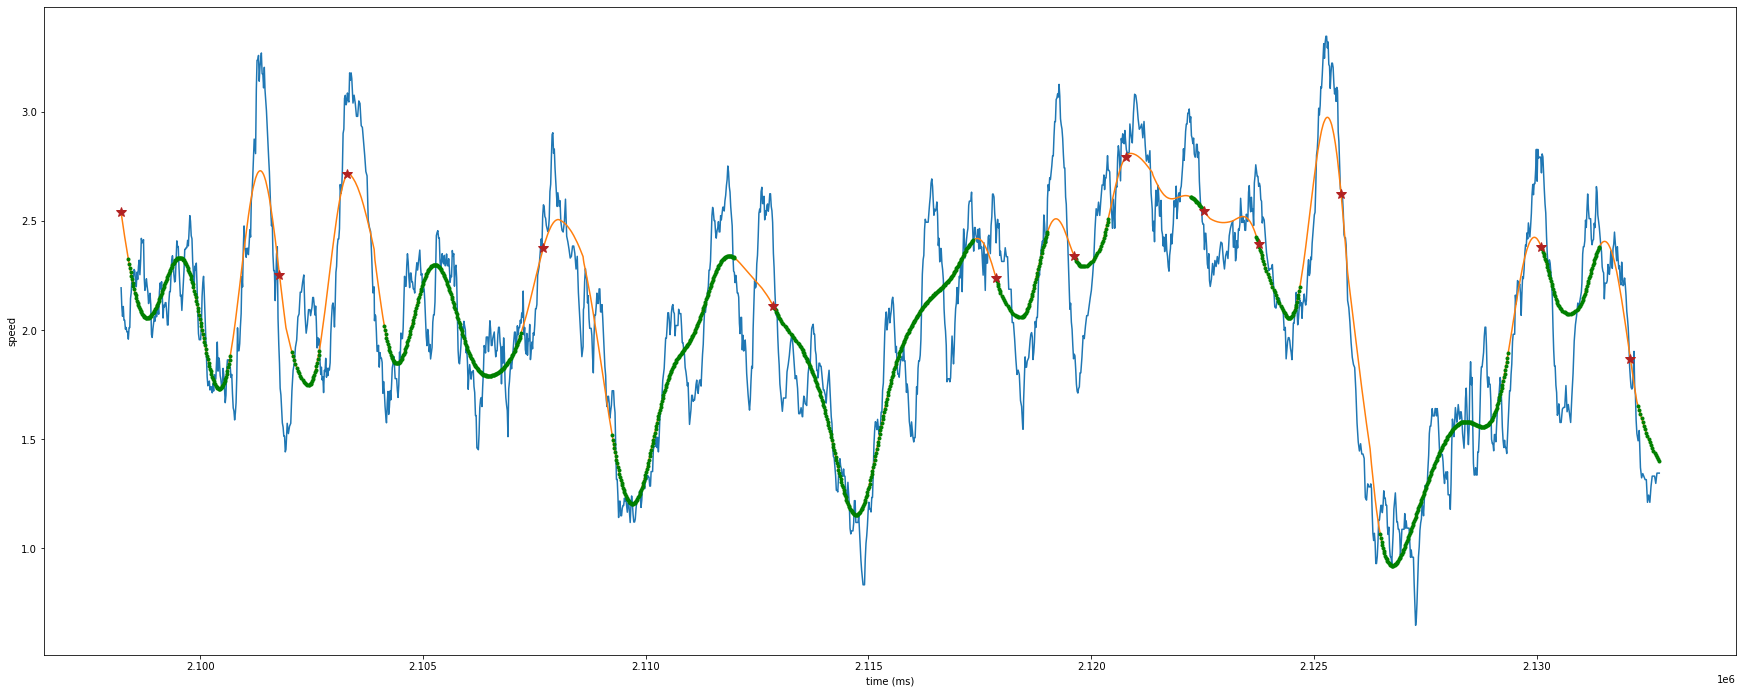

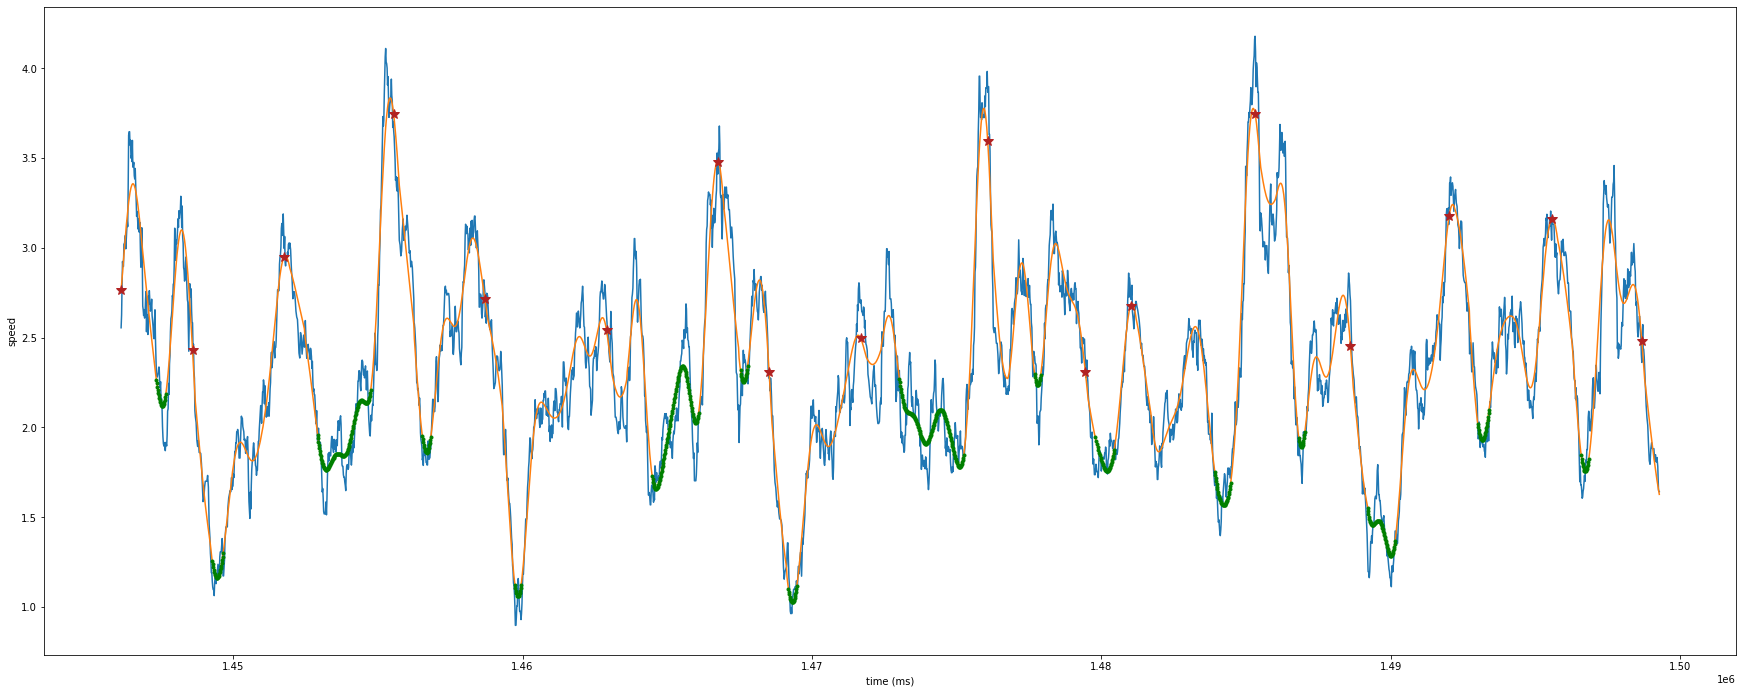

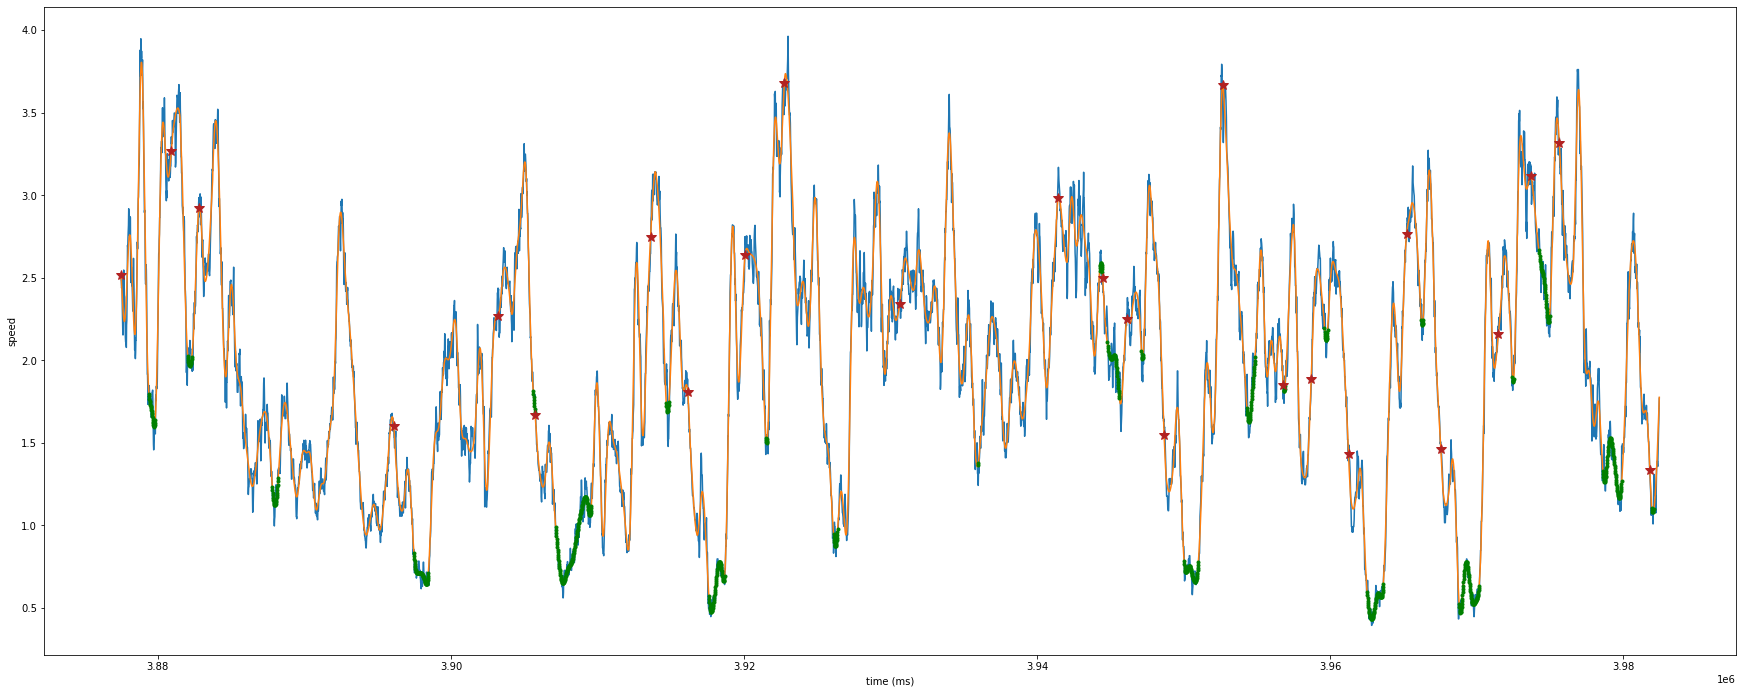

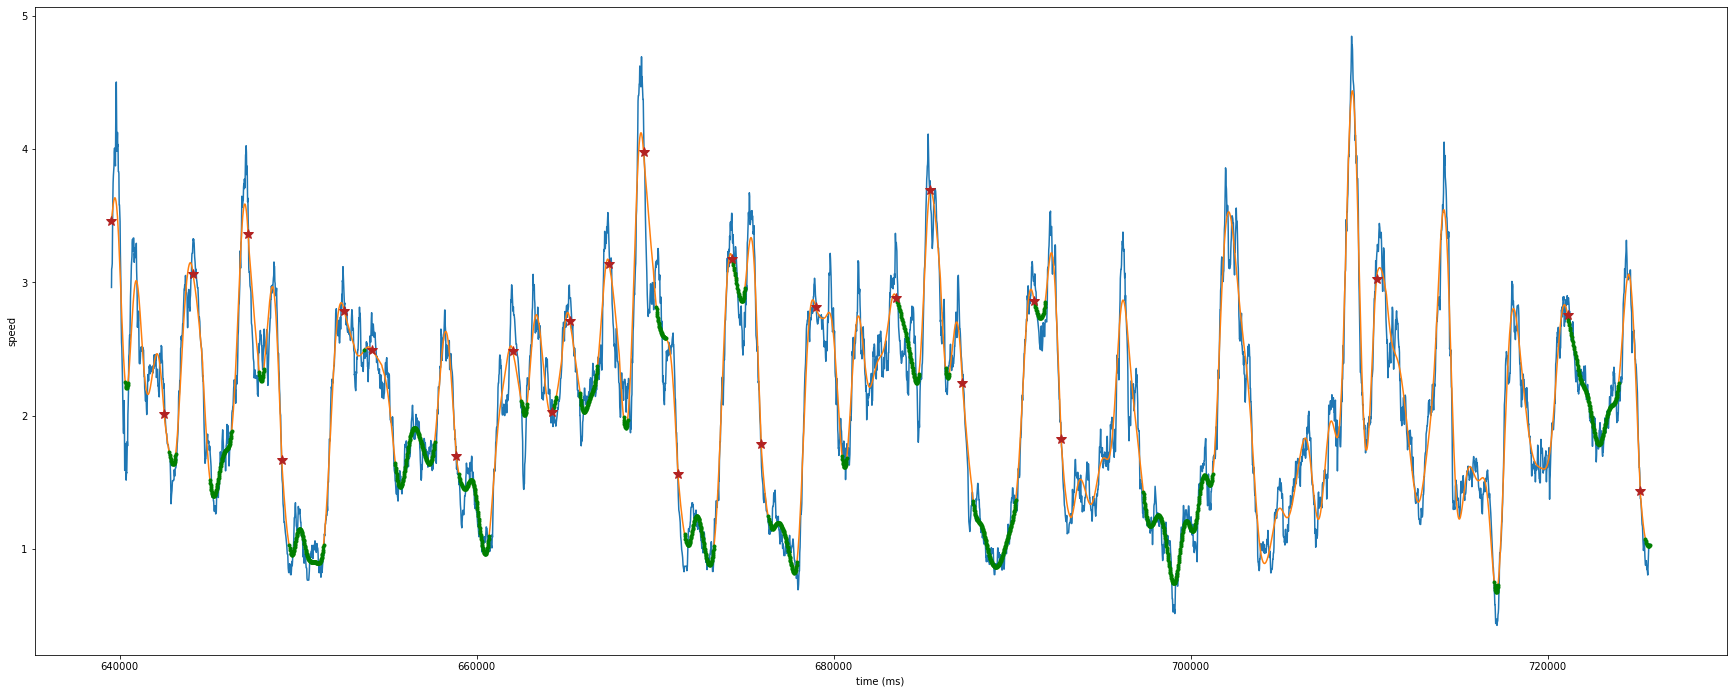

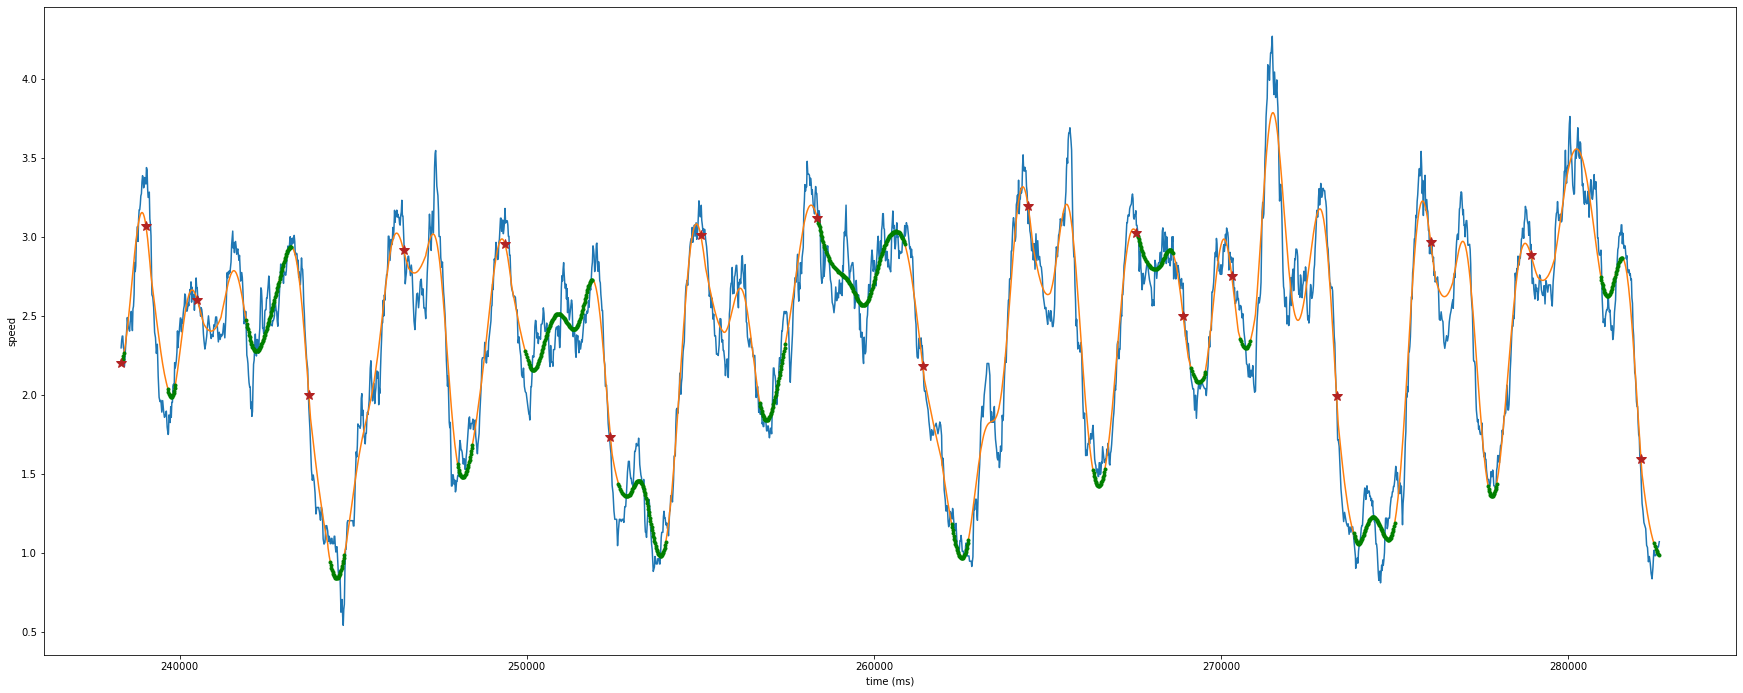

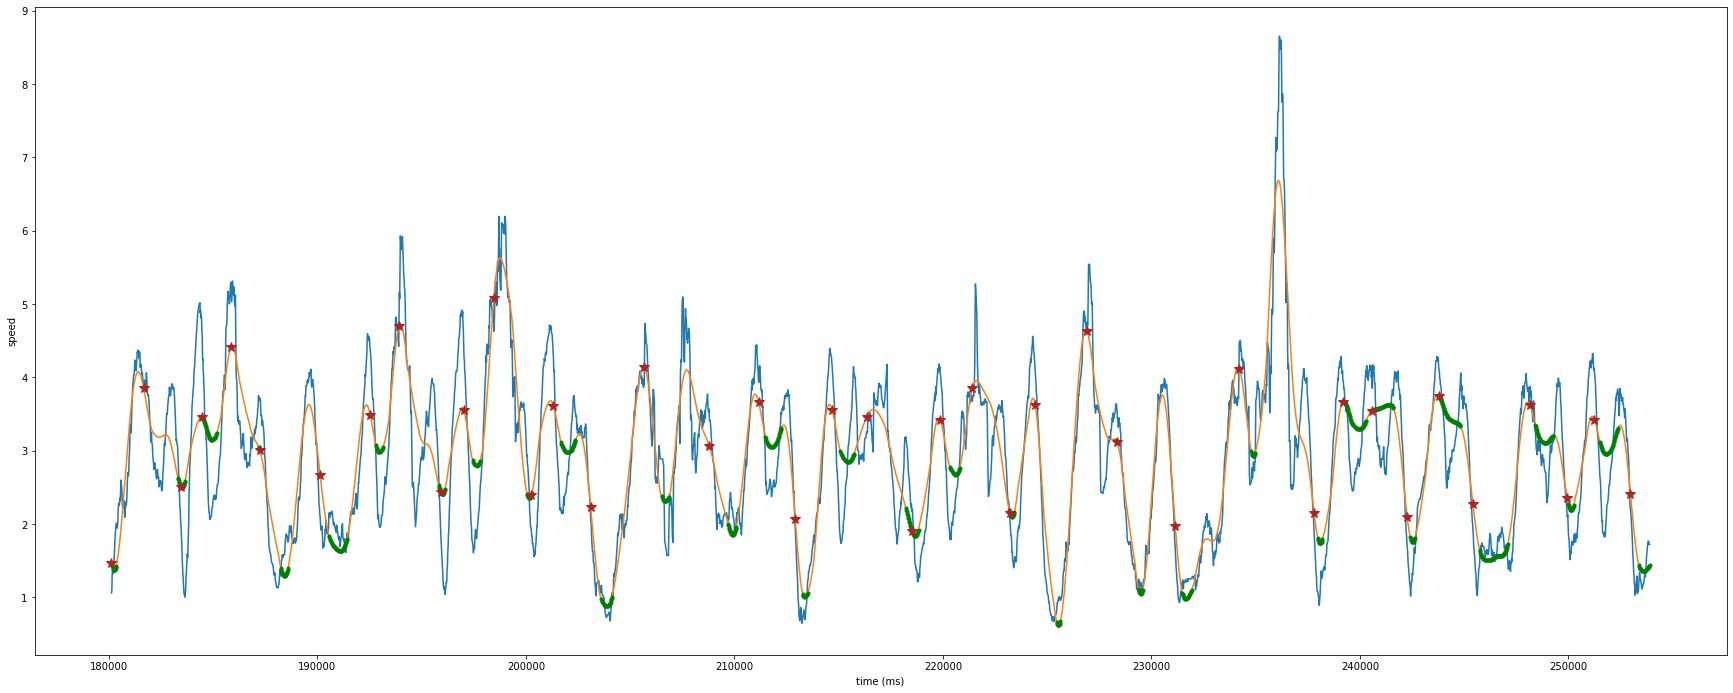

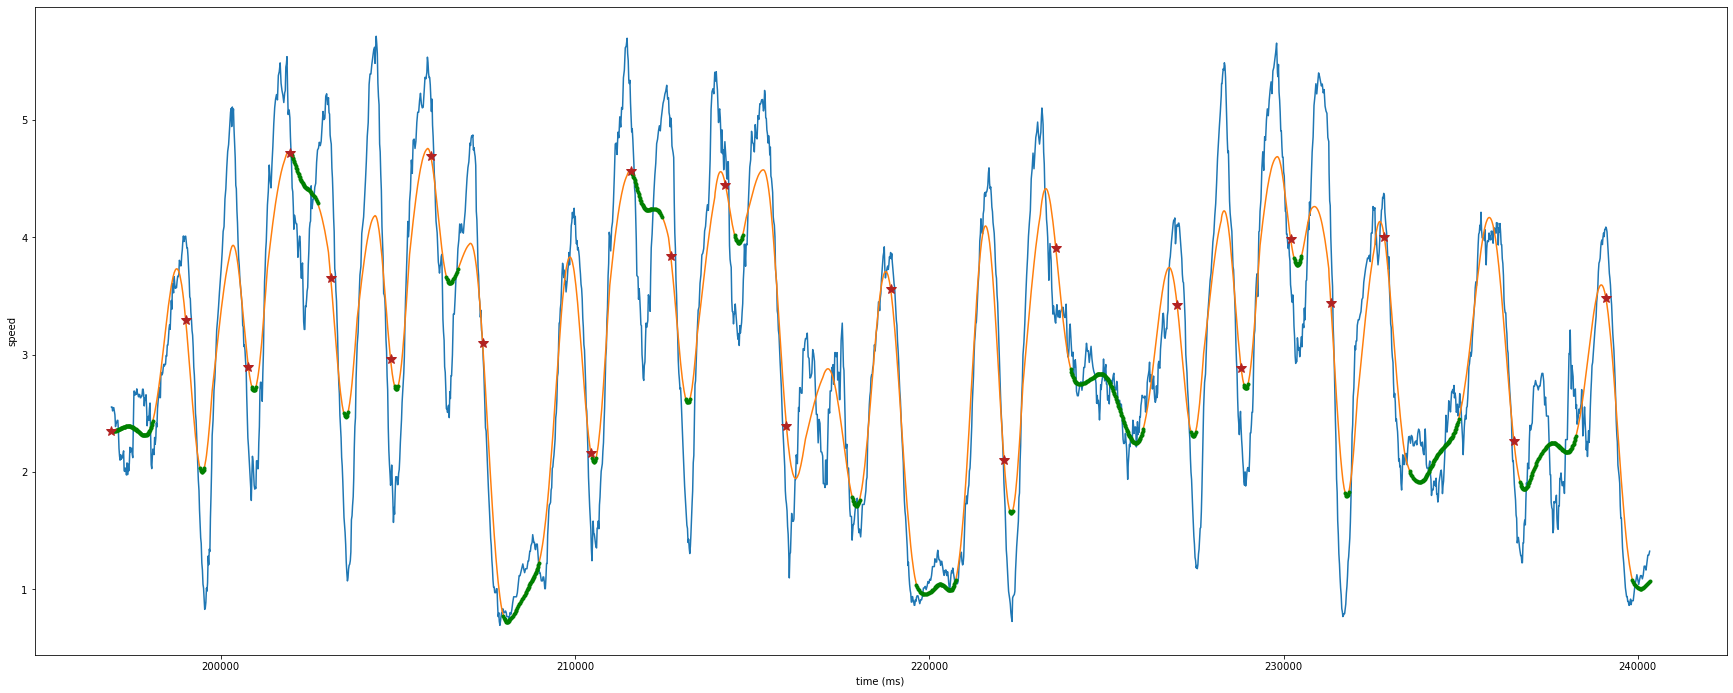

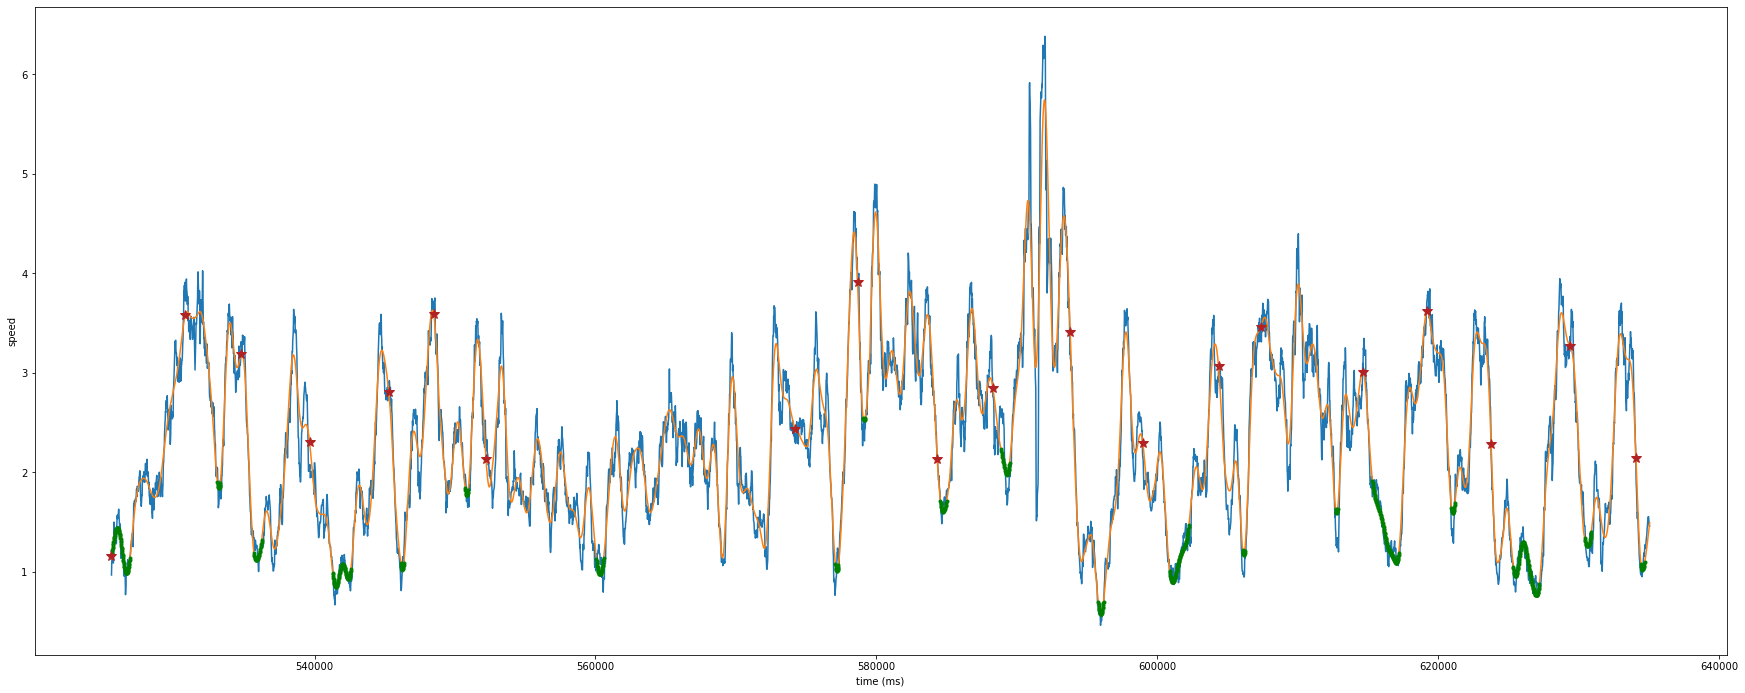

In [87]:
for ef in exp_files:
    print(ef)
    exp_type = ef.split('/')[-1].split("velocity_profiles_")[1].split('.')[0].split('_')[0]
    print(exp_type)
    vel_prof = pd.read_csv(ef)
    
    decision_times = calc_decision_times(vel_prof,exp_type)
    
    decision_times.to_csv(data_target_dir+"decision_times_"+exp_type+".csv")
    
    decision_times_all_conditions = decision_times_all_conditions.append(decision_times)

decision_times_all_conditions = decision_times_all_conditions.reset_index()
decision_times_all_conditions.to_csv(data_target_dir+"decision_times_new_method.csv")
    


In [88]:
decision_times_all_conditions

,index,session,animal_id,conflict,volatility,condition,block_num,trial_num,event_marker,chosen_action,rewarded,block,optimal_action,rt,reward_probability
0,0,0.0,1.0,Low,Low,iSPN-Stim,1.0,0.0,5.0,right,rewarded,right,1.0,16.0,NaN
1,1,0.0,1.0,Low,Low,iSPN-Stim,1.0,1.0,4.0,left,unrewarded,right,0.0,194.0,NaN
2,2,0.0,1.0,Low,Low,iSPN-Stim,1.0,2.0,4.0,left,unrewarded,right,0.0,4662.0,NaN
3,3,0.0,1.0,Low,Low,iSPN-Stim,1.0,3.0,4.0,left,unrewarded,right,0.0,1089.0,NaN
4,4,0.0,1.0,Low,Low,iSPN-Stim,1.0,4.0,4.0,left,unrewarded,right,0.0,503.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324814,16992,29.0,6.0,Low,High,dSPN-Stim,30.0,1.0,1.0,left,rewarded,left,1.0,876.0,NaN
324815,16993,29.0,6.0,Low,High,dSPN-Stim,30.0,2.0,7.0,right,rewarded,left,0.0,1089.0,NaN
324816,16994,29.0,6.0,Low,High,dSPN-Stim,30.0,3.0,1.0,left,rewarded,left,1.0,291.0,NaN
324817,16995,29.0,6.0,Low,High,dSPN-Stim,30.0,4.0,1.0,left,rewarded,left,1.0,634.0,NaN


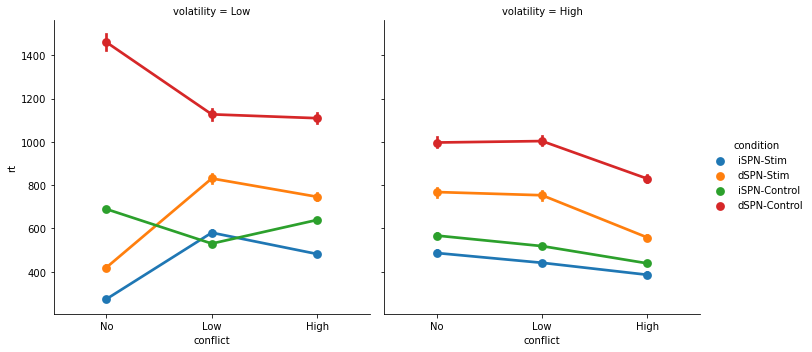

In [89]:
sns.catplot(x="conflict",y="rt",col="volatility",hue="condition",data=decision_times_all_conditions,kind='point',order=["No","Low","High"],col_order=["Low","High"])

In [90]:
decision_times_all_conditions["conflict + volatility"] = [x+'-'+y   for x,y in zip(decision_times_all_conditions["conflict"],decision_times_all_conditions["volatility"]) ]

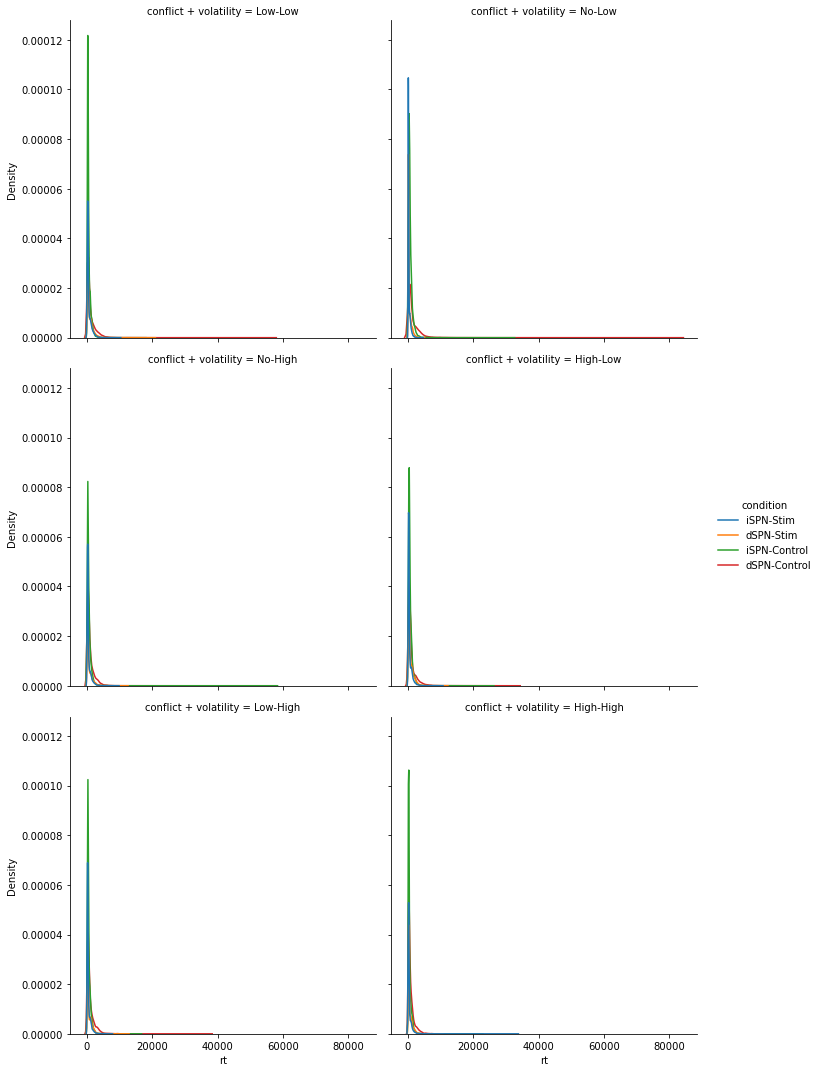

In [91]:
sns.displot(x="rt",col="conflict + volatility",hue="condition",data=decision_times_all_conditions,kind='kde',col_wrap=2)